In [ ]:
!pip install torch torchvision torchaudio
!pip install scikit-learn
!pip install kagglehub
!pip install opencv-python
!pip install matplotlib
!pip install tqdm

In [ ]:
import kagglehub
import os

# Download the dataset
# The local path to the downloaded files is returned and stored in dataset_path
dataset_path = kagglehub.dataset_download("anirudhcv/labeled-optical-coherence-tomography-oct")
print("Path to dataset files:", dataset_path)

# --- Path Correction Logic ---
# The actual data root might be nested inside the downloaded folder.
# We check if the expected 'OCT2017' folder exists and adjust the path.
expected_data_dir = os.path.join(dataset_path, "OCT2017", "Dataset - train+val+test")

if os.path.exists(expected_data_dir):
    DATA_ROOT = expected_data_dir
else:
    # Fallback/alternative structure check if the files were flattened
    # This might happen if 'OCT2017' was the root of the archive.
    DATA_ROOT = os.path.join(dataset_path, "Dataset - train+val+test")

if not os.path.exists(DATA_ROOT):
    print("Warning: Could not find the expected data directory structure.")
    print("Please manually check the contents of:", dataset_path)

print("Data Root Directory:", DATA_ROOT)

100%|██████████| 6.70G/6.70G [05:32<00:00, 21.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/anirudhcv/labeled-optical-coherence-tomography-oct/versions/2
Data Root Directory: /root/.cache/kagglehub/datasets/anirudhcv/labeled-optical-coherence-tomography-oct/versions/2/Dataset - train+val+test


In [ ]:
# Necessary imports for general file operations and path manipulation
import os
import shutil
import glob

In [ ]:
# Core PyTorch and TorchVision imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
# Imports for utility functions and visualization
from tqdm import tqdm
import collections
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define paths to dataset splits using the corrected DATA_ROOT from Cell 2
# This should now point to the correct directory containing 'train', 'val', 'test'
train_dir = os.path.join(DATA_ROOT, "train")
val_dir = os.path.join(DATA_ROOT, "val")
test_dir = os.path.join(DATA_ROOT, "test")

# Verify the classes (folders) in each directory
print("Train classes:", os.listdir(train_dir))
print("Validation classes:", os.listdir(val_dir))
print("Test classes:", os.listdir(test_dir))

def count_per_class(data_dir):
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

print("\nTrain Counts:", count_per_class(train_dir))
print("Validation Counts:", count_per_class(val_dir))
print("Test Counts:", count_per_class(test_dir))

Train classes: ['NORMAL', 'DME', 'CNV', 'DRUSEN']
Validation classes: ['NORMAL', 'DME', 'CNV', 'DRUSEN']
Test classes: ['NORMAL', 'DME', 'CNV', 'DRUSEN']

Train Counts: {'NORMAL': 35973, 'DME': 8118, 'CNV': 26218, 'DRUSEN': 6206}
Validation Counts: {'NORMAL': 10278, 'DME': 2319, 'CNV': 7491, 'DRUSEN': 1773}
Test Counts: {'NORMAL': 5139, 'DME': 1161, 'CNV': 3746, 'DRUSEN': 887}


In [ ]:
# Standard ImageNet normalization parameters
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Data augmentation for training
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# No augmentation for validation/test
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load the datasets using the corrected directory paths
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
val_data = datasets.ImageFolder(val_dir, transform=val_transforms)
test_data = datasets.ImageFolder(test_dir, transform=val_transforms)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train dataset size: {len(train_data.samples)}")
print(f"Validation dataset size: {len(val_data.samples)}")
print(f"Test dataset size: {len(test_data.samples)}")

print("Class indices:", train_data.class_to_idx)

Train dataset size: 76515
Validation dataset size: 21861
Test dataset size: 10933
Class indices: {'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


In [ ]:
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

class ResNet50Custom(nn.Module):
    """
    A custom wrapper around a pretrained ResNet50 model for 4-class classification.
    """
    def __init__(self, num_classes=4, freeze_features=False):
        super(ResNet50Custom, self).__init__()

        # Load pre-trained ResNet50 model weights
        weights = ResNet50_Weights.DEFAULT
        self.model = resnet50(weights=weights)

        if freeze_features:
            # Freeze all the feature extraction layers
            for param in self.model.parameters():
                param.requires_grad = False

        # Modify the final fully connected layer (classifier)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

print("ResNet50 model with modified final classification layer defined.")

ResNet50 model with modified final classification layer defined.


In [ ]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model initialization: freeze_features=False allows the whole network to be trained
model = ResNet50Custom(num_classes=len(train_data.classes), freeze_features=False).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam, targeting only parameters that require gradients
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)

print('Device:', device)
print('Model initialized with', len(train_data.classes), 'classes.')
print('Optimizer targeting', len(list(filter(lambda p: p.requires_grad, model.parameters()))), 'trainable parameters.')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]


Device: cuda
Model initialized with 4 classes.
Optimizer targeting 163 trainable parameters.


In [11]:
from PIL import Image
from google.colab import drive
import random
import cv2
import numpy as np

# Mount Google Drive to save results
drive.mount('/content/drive')
results_dir = "/content/drive/MyDrive/OCT_ResNet50_Visualization01"
os.makedirs(results_dir, exist_ok=True)
print(f"Results will be saved to: {results_dir}")

# Denormalize function (reverses ImageNet normalization)
mean_t = torch.tensor(mean).view(3, 1, 1)
std_t = torch.tensor(std).view(3, 1, 1)

def denormalize(img_tensor: torch.Tensor) -> torch.Tensor:
    """Reverses the normalization for visualization."""
    return img_tensor * std_t.to(img_tensor.device) + mean_t.to(img_tensor.device)

def fmap_to_heatmap(fmap: torch.Tensor):
    """Converts a feature map tensor to a normalized heatmap numpy array."""
    fmap_np = fmap.mean(dim=0).cpu().numpy() # Mean across channels

    # Min-Max scaling to [0, 1]
    min_val = fmap_np.min()
    max_val = fmap_np.max()
    if max_val == min_val:
        return np.zeros_like(fmap_np, dtype=np.float32)
    return (fmap_np - min_val) / (max_val - min_val)

# Prepare mapping for sampling (using data from Cell 7)
paths_by_label = {i: [] for i in range(len(train_data.classes))}
for path, label in train_data.samples:
    paths_by_label[label].append(path)

# Create index-to-class name map
idx_to_class = {v: k for k, v in train_data.class_to_idx.items()}

# Grad-CAM Setup (Forward Hooks for ResNet50)
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Hook target layers for ResNet50:
# 'conv1': The very first conv layer (early features)
h1 = model.model.conv1.register_forward_hook(get_activation("conv1"))
# 'conv4': The last block of the final convolutional layer (layer4) (late features)
h2 = model.model.layer4.register_forward_hook(get_activation("conv4"))


num_epochs = 10
print(f"Starting training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_data)
    epoch_acc = correct_train / total_train
    print(f"\nEpoch {epoch+1} - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

    # Intermediate Visualization Phase
    model.eval()
    epoch_folder = os.path.join(results_dir, f"epoch_{epoch+1:02d}")
    os.makedirs(epoch_folder, exist_ok=True)

    selected = {}
    for label_idx, paths in paths_by_label.items():
        k = min(5, len(paths))
        selected[label_idx] = random.sample(paths, k)

    with torch.no_grad():
        for label_idx, paths in selected.items():
            for i, img_path in enumerate(paths):
                # 1. Prepare image
                img = Image.open(img_path).convert("RGB")
                # Using val_transforms as training transforms include random augmentations (e.g. flips)
                x = val_transforms(img).unsqueeze(0).to(device)

                # 2. Forward pass to get activations and prediction
                logits = model(x)
                probs = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()
                pred_idx = torch.argmax(logits, dim=1).item()

                # 3. Retrieve and convert feature maps to heatmaps
                # ResNet50 early features: output of conv1
                conv1 = activations.get("conv1")
                hm1 = fmap_to_heatmap(conv1[0])
                # ResNet50 late features: output of layer4
                conv4 = activations.get("conv4")
                hm4 = fmap_to_heatmap(conv4[0])

                # 4. Visualization and Saving
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                fig.suptitle(f"Epoch {epoch+1} | True: {idx_to_class.get(label_idx)} | Pred: {idx_to_class.get(pred_idx)} ({probs[pred_idx]*100:.1f}%)", fontsize=16)

                # ResNet input requires upsampling of feature maps for overlay
                hm1_resized = cv2.resize(hm1, (224, 224))
                hm4_resized = cv2.resize(hm4, (224, 224))

                # Display Denormalized Input Image
                input_img_np = denormalize(x[0]).permute(1, 2, 0).cpu().numpy().clip(0, 1)

                # Plot Original
                axs[0].imshow(input_img_np)
                axs[0].set_title("Input Image")
                axs[0].axis('off')

                # Plot Early Features Overlay
                axs[1].imshow(input_img_np)
                axs[1].imshow(hm1_resized, cmap='jet', alpha=0.5)
                axs[1].set_title("Early Features (conv1)")
                axs[1].axis('off')

                # Plot Late Features Overlay
                axs[2].imshow(input_img_np)
                axs[2].imshow(hm4_resized, cmap='jet', alpha=0.5)
                axs[2].set_title("Late Features (layer4)")
                axs[2].axis('off')

                # Save plot
                class_name = idx_to_class.get(label_idx)
                out_path = os.path.join(epoch_folder, f"{class_name}_{i:02d}.png")
                plt.tight_layout()
                plt.savefig(out_path, dpi=100)
                plt.close(fig)

# Cleanup: Remove hooks after training
h1.remove()
h2.remove()

Mounted at /content/drive
Results will be saved to: /content/drive/MyDrive/OCT_ResNet50_Visualization01
Starting training for 10 epochs...


Epoch 1/10 Training: 100%|██████████| 2392/2392 [13:39<00:00,  2.92it/s]



Epoch 1 - Loss: 0.2322, Acc: 0.9283


Epoch 2/10 Training: 100%|██████████| 2392/2392 [13:22<00:00,  2.98it/s]



Epoch 2 - Loss: 0.1802, Acc: 0.9453


Epoch 3/10 Training: 100%|██████████| 2392/2392 [13:11<00:00,  3.02it/s]



Epoch 3 - Loss: 0.1600, Acc: 0.9509


Epoch 4/10 Training: 100%|██████████| 2392/2392 [13:01<00:00,  3.06it/s]



Epoch 4 - Loss: 0.1460, Acc: 0.9545


Epoch 5/10 Training: 100%|██████████| 2392/2392 [12:50<00:00,  3.10it/s]



Epoch 5 - Loss: 0.1341, Acc: 0.9574


Epoch 6/10 Training: 100%|██████████| 2392/2392 [12:44<00:00,  3.13it/s]



Epoch 6 - Loss: 0.1291, Acc: 0.9586


Epoch 7/10 Training: 100%|██████████| 2392/2392 [12:39<00:00,  3.15it/s]



Epoch 7 - Loss: 0.1275, Acc: 0.9593


Epoch 8/10 Training: 100%|██████████| 2392/2392 [12:37<00:00,  3.16it/s]



Epoch 8 - Loss: 0.1248, Acc: 0.9597


Epoch 9/10 Training: 100%|██████████| 2392/2392 [12:36<00:00,  3.16it/s]



Epoch 9 - Loss: 0.1204, Acc: 0.9613


Epoch 10/10 Training: 100%|██████████| 2392/2392 [12:36<00:00,  3.16it/s]



Epoch 10 - Loss: 0.1184, Acc: 0.9619


In [12]:
# Define save path
save_path = "/content/resnet50_oct_best01.pth"

# Get class index mapping
class_to_idx = train_data.class_to_idx

# Save model state dictionary and class mapping
torch.save({
    "state_dict": model.state_dict(),
    "class_to_idx": class_to_idx
}, save_path)

print(f"Trained ResNet50 model saved to {save_path}")

Trained ResNet50 model saved to /content/resnet50_oct_best01.pth


In [13]:
# Import necessary evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [14]:
# Import utility for visualization (already imported, but safe to include)
import matplotlib.pyplot as plt

In [15]:
def evaluate(model, loader, class_names, device):
    """Calculates accuracy, confusion matrix, and classification report."""
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, target_names=class_names, digits=4)

    print(f"\nAccuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", cr)

    return accuracy

# Load the saved model for evaluation
ckpt_path = "/content/resnet50_oct_best01.pth"
checkpoint = torch.load(ckpt_path, map_location=device)

# Instantiate the model structure
model_eval = ResNet50Custom(num_classes=len(train_data.classes)).to(device)
model_eval.load_state_dict(checkpoint["state_dict"])
model_eval.eval()

# Get class names
class_names = [k for k, v in sorted(train_data.class_to_idx.items(), key=lambda item: item[1])]

print("== Validation on ResNet50 ==")
val_acc = evaluate(model_eval, val_loader, class_names, device)

print("\n== Testing on ResNet50 ==")
test_acc = evaluate(model_eval, test_loader, class_names, device)

== Validation on ResNet50 ==


Evaluating: 100%|██████████| 684/684 [02:22<00:00,  4.80it/s]



Accuracy: 0.9559

Confusion Matrix:
 [[ 7360    26   101     4]
 [  202  1997     9   111]
 [  245     4  1464    60]
 [   79    31    91 10077]]

Classification Report:
               precision    recall  f1-score   support

         CNV     0.9333    0.9825    0.9573      7491
         DME     0.9704    0.8611    0.9125      2319
      DRUSEN     0.8793    0.8257    0.8517      1773
      NORMAL     0.9829    0.9804    0.9817     10278

    accuracy                         0.9559     21861
   macro avg     0.9415    0.9125    0.9258     21861
weighted avg     0.9562    0.9559    0.9554     21861


== Testing on ResNet50 ==


Evaluating: 100%|██████████| 342/342 [01:11<00:00,  4.77it/s]


Accuracy: 0.9521

Confusion Matrix:
 [[3685   15   43    3]
 [ 101 1012    1   47]
 [ 140    2  710   35]
 [  52   25   60 5002]]

Classification Report:
               precision    recall  f1-score   support

         CNV     0.9263    0.9837    0.9542      3746
         DME     0.9602    0.8717    0.9138      1161
      DRUSEN     0.8722    0.8005    0.8348       887
      NORMAL     0.9833    0.9733    0.9783      5139

    accuracy                         0.9521     10933
   macro avg     0.9355    0.9073    0.9203     10933
weighted avg     0.9523    0.9521    0.9515     10933



In [16]:
# Instantiate the ResNet50 model structure
model = ResNet50Custom(num_classes=4)

# Calculate total number of parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total number of parameters (ResNet50): {total_params:,}")
print(f"Number of trainable parameters: {trainable_params:,}")

Total number of parameters (ResNet50): 24,559,172
Number of trainable parameters: 24,559,172


In [17]:
# Calculate total size of model in bytes
param_size_bytes = sum(p.numel() * p.element_size() for p in model.parameters())

# Convert to MB
model_size_mb = param_size_bytes / (1024**2)

print(f"Model size: {model_size_mb:.2f} MB")

Model size: 93.69 MB


Please upload an OCT image file (.jpeg, .png) for prediction and Grad-CAM visualization.


Saving NORMAL-1027133-1.jpeg to NORMAL-1027133-1.jpeg
Saving DRUSEN-1094282-15.jpeg to DRUSEN-1094282-15.jpeg
Saving DME-1645804-5.jpeg to DME-1645804-5.jpeg
Saving CNV-1016042-111.jpeg to CNV-1016042-111.jpeg


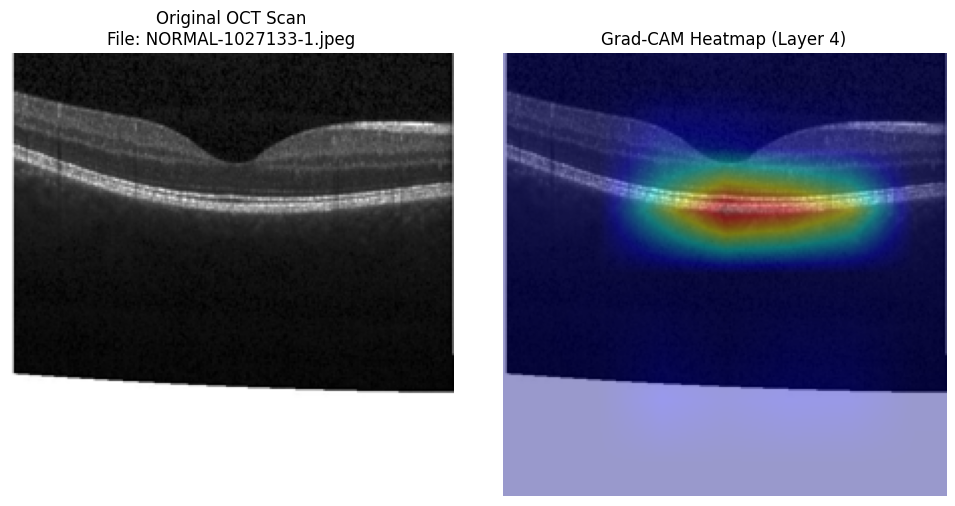


--- AI-Based Biomarker Detection (ResNet50) ---
Predicted Class: **NORMAL**
Confidence: **99.44%**
Biomarker Detected: **No significant biomarkers detected**
Associated Ocular Disease: **Normal Retina**
All Probabilities: CNV: 0.00%, DME: 0.00%, DRUSEN: 0.56%, NORMAL: 99.44%



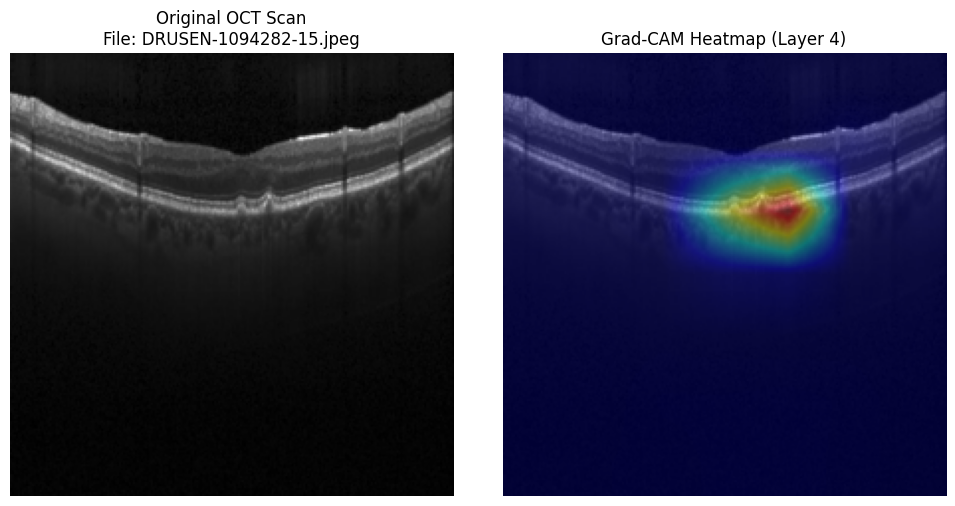


--- AI-Based Biomarker Detection (ResNet50) ---
Predicted Class: **DRUSEN**
Confidence: **99.27%**
Biomarker Detected: **Drusen**
Associated Ocular Disease: **Dry Age-Related Macular Degeneration (AMD)**
All Probabilities: CNV: 0.55%, DME: 0.00%, DRUSEN: 99.27%, NORMAL: 0.18%



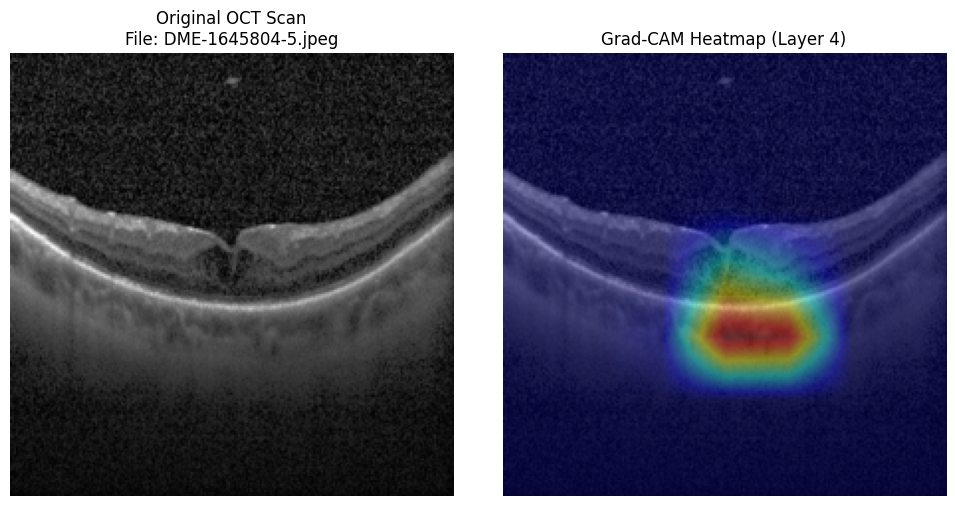


--- AI-Based Biomarker Detection (ResNet50) ---
Predicted Class: **DME**
Confidence: **99.99%**
Biomarker Detected: **Diabetic Macular Edema (DME)**
Associated Ocular Disease: **Diabetic Retinopathy**
All Probabilities: CNV: 0.01%, DME: 99.99%, DRUSEN: 0.00%, NORMAL: 0.00%



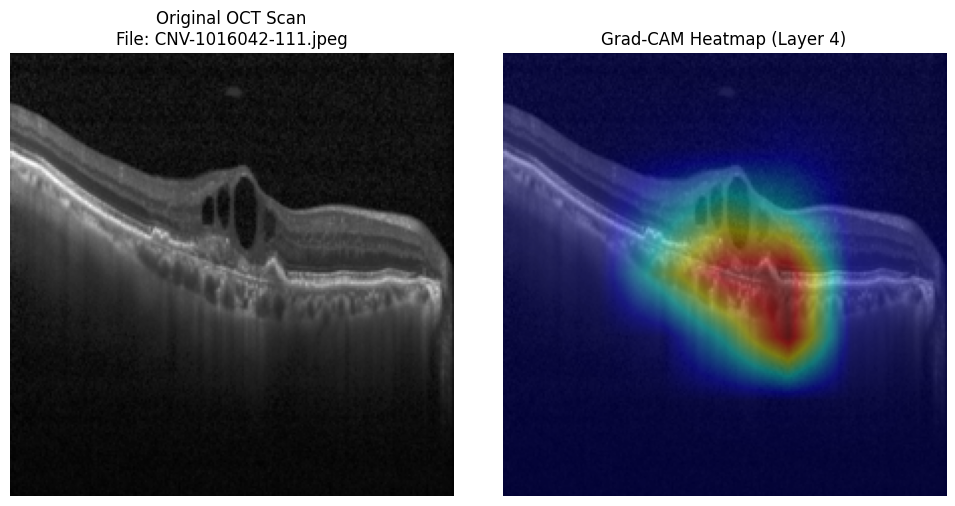


--- AI-Based Biomarker Detection (ResNet50) ---
Predicted Class: **CNV**
Confidence: **99.99%**
Biomarker Detected: **Choroidal Neovascularization (CNV)**
Associated Ocular Disease: **Wet Age-Related Macular Degeneration (AMD)**
All Probabilities: CNV: 99.99%, DME: 0.00%, DRUSEN: 0.01%, NORMAL: 0.00%



In [19]:
from google.colab import files
from PIL import Image
import cv2
import numpy as np
import os # Ensure os is imported here

# Re-define the model structure for inference environment
class ResNet50Custom(nn.Module):
    def __init__(self, num_classes=4, freeze_features=False):
        super(ResNet50Custom, self).__init__()
        weights = ResNet50_Weights.DEFAULT
        self.model = resnet50(weights=weights)
        if freeze_features:
            for param in self.model.parameters():
                param.requires_grad = False
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        return self.model(x)

# Data preprocessing transformations
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Model Loading
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt_path = "/content/resnet50_oct_best01.pth"

checkpoint = torch.load(ckpt_path, map_location=device)
model = ResNet50Custom(num_classes=len(checkpoint["class_to_idx"])).to(device)
model.load_state_dict(checkpoint["state_dict"])
model.eval()

# Class mapping
class_to_idx = checkpoint["class_to_idx"]
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Biomarker/Disease Mapping
biomarker_map = {
    'CNV': 'Choroidal Neovascularization (CNV)',
    'DME': 'Diabetic Macular Edema (DME)',
    'DRUSEN': 'Drusen',
    'NORMAL': 'No significant biomarkers detected'
}

disease_map = {
    'CNV': 'Wet Age-Related Macular Degeneration (AMD)',
    'DME': 'Diabetic Retinopathy',
    'DRUSEN': 'Dry Age-Related Macular Degeneration (AMD)',
    'NORMAL': 'Normal Retina'
}

# Grad-CAM Implementation
class GradCAM:
    """Class to implement Grad-CAM visualization."""
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        def forward_hook(module, inp, out):
            self.activations = out.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        # Register hooks to the target layer
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, class_idx):
        # Pool the gradients across the spatial dimensions
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)

        # Compute CAM: dot product of weights and activations
        cam = weights * self.activations
        cam = torch.sum(cam, dim=1).squeeze()

        # Apply ReLU to retain only positive contributions
        cam = torch.relu(cam)

        # Normalize the CAM to [0, 1]
        cam_min, cam_max = cam.min(), cam.max()
        if cam_max != cam_min:
            cam = (cam - cam_min) / (cam_max - cam_min)
        else:
            cam = torch.zeros_like(cam)

        return cam.cpu().numpy()

def predict_image(image_path, model, idx_to_class, class_to_idx, transform, threshold=0.90, show_probs=True, device='cpu'):
    """Performs prediction and Grad-CAM visualization for a single image."""

    # 1. Image Preprocessing
    try:
        img = Image.open(image_path).convert("RGB")
    except Exception as e:
        return f"Error opening image: {e}"

    x = transform(img).unsqueeze(0).to(device)

    # 2. Setup Grad-CAM - Target: The last convolutional block (layer4)
    target_layer = model.model.layer4
    gradcam = GradCAM(model, target_layer)

    # 3. Forward Pass
    logits = model(x)
    probs = torch.softmax(logits, dim=1).detach().cpu().numpy()[0]
    pred_idx = torch.argmax(logits, dim=1).item()
    conf = probs[pred_idx]
    pred_class = idx_to_class[pred_idx]

    if conf < threshold:
        return (f"Warning: Model confidence ({conf*100:.2f}%) is below the threshold. "
                f"Prediction: {pred_class} | Probabilities: {probs}")

    # 4. Backward Pass for Grad-CAM
    model.zero_grad()
    # Backpropagate from the predicted class's logit
    logits[0, pred_idx].backward(retain_graph=True)

    # 5. Generate and Process CAM
    cam = gradcam.generate(pred_idx)

    # Resize and color the heatmap
    cam_resized = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap((cam_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Convert original image to numpy for blending
    img_np = np.array(img.resize((224, 224)))

    # Blend original image and heatmap
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    # 6. Visualization
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Original Image
    axs[0].imshow(img_np)
    axs[0].set_title(f"Original OCT Scan\nFile: {os.path.basename(image_path)}")
    axs[0].axis('off')

    # Grad-CAM Overlay
    axs[1].imshow(overlay)
    axs[1].set_title(f"Grad-CAM Heatmap (Layer 4)")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

    # 7. Results
    if show_probs:
        prob_str = ", ".join([f"{idx_to_class[i]}: {p*100:.2f}%" for i, p in enumerate(probs)])

    biomarker = biomarker_map[pred_class]
    disease = disease_map[pred_class]

    return (
        f"\n--- AI-Based Biomarker Detection (ResNet50) ---\n"
        f"Predicted Class: **{pred_class}**\n"
        f"Confidence: **{conf*100:.2f}%**\n"
        f"Biomarker Detected: **{biomarker}**\n"
        f"Associated Ocular Disease: **{disease}**\n"
        f"All Probabilities: {prob_str}\n"
    )

print("Please upload an OCT image file (.jpeg, .png) for prediction and Grad-CAM visualization.")
uploaded = files.upload()

for filename in uploaded.keys():
    print(predict_image(filename, model, idx_to_class, class_to_idx, transform, device=device))